In [1]:
import pandas as pd

df = pd.read_csv("../Data/housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
print(df.columns)
df.info()

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Val av variabler

Responsvariabeln som används är `median_house_value`, vilket representerar det genomsnittliga bostadspriset i varje område.

Som förklarande variabler har `median_income`, `housing_median_age` och `population` valts.  
`median_income` har ett starkt och välkänt samband med bostadspriser och är därför central i modellen.  
`housing_median_age` ger information om områdets bebyggelsestruktur och kompletterar inkomstvariabeln.  
`population` används för att fånga områdets storlek och befolkningstäthet.


**Creates scatter plots showing how each housing feature relates to house value**


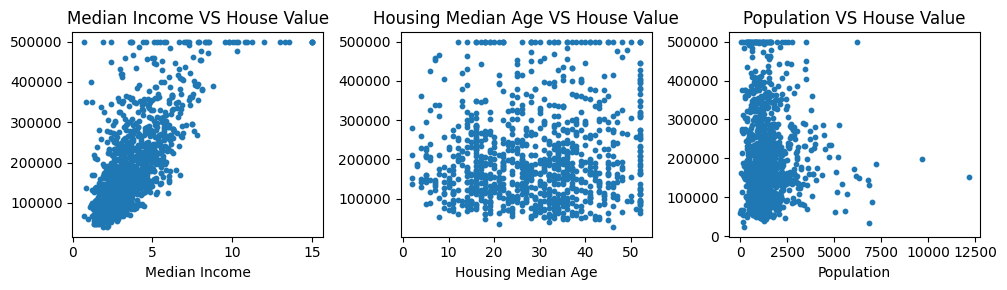

In [4]:
import matplotlib.pyplot as plt
import numpy as np

y = df['median_house_value'].to_numpy()
X = df[['median_income', 'housing_median_age', 'population']].to_numpy()
features = ['median_income', 'housing_median_age', 'population']

fig, ax = plt.subplots(1, X.shape[1], figsize=(10,3), dpi=100)

for i in range(X.shape[1]):
    idx = np.random.choice(len(y), 1000, replace=False)
    ax[i].scatter(X[idx, i], y[idx], s=10)
    ax[i].set(xlabel=features[i].replace("_", " ").title(), 
            title=f"{features[i].replace("_", " ").title()} VS House Value")

plt.tight_layout()


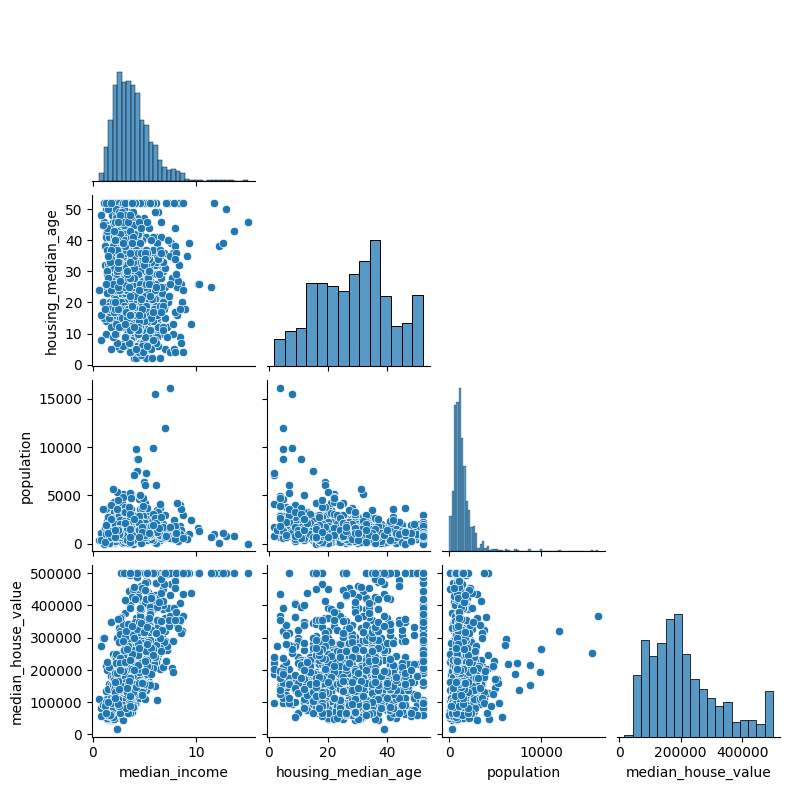

In [5]:
import seaborn as sns

cols = ['median_income', 'housing_median_age', 'population', 'median_house_value']
df_s = df[cols].sample(1000, random_state=42)
ax = sns.pairplot(df_s, corner=True, height=2)



### **Pairplot**

Pairploten ger en översikt av de parvisa relationerna mellan de valda variablerna i bostadsdatasetet.

Resultatet visar ett tydligt och ungefär linjärt positivt samband mellan **median_income** och **median_house_value**, vilket indikerar att högre inkomstnivåer är starkt associerade med högre huspriser. Sambanden mellan **housing_median_age**, **population** och husvärde är svagare och uppvisar större spridning, vilket tyder på begränsad förklaringskraft i relation till målvariabeln.

Histogrammen längs diagonalen visar att flera variabler är snedfördelade, särskilt **population** och **median_house_value**

In [6]:
df_s.corr()

,median_income,housing_median_age,population,median_house_value
median_income,1.000000,-0.100599,0.052780,0.701940
housing_median_age,-0.100599,1.000000,-0.319637,0.122964
population,0.052780,-0.319637,1.000000,-0.007168
median_house_value,0.701940,0.122964,-0.007168,1.000000


In [ ]:
import numpy as np
from Linear_regression import LinearRegression  # ändra om din fil heter något annat

# Fit modellen
model = LinearRegression(add_intercept=True)
print(model)
model.fit(X, y)
print(model)

# Koefficienter (b)
b = model.beta_
print("=== Linear Regression (G) ===\n")

print("Koefficienter (beta):")
print(f"Intercept (b0): {b[0]:.6f}")
for i, name in enumerate(["median_income", "housing_median_age", "population"], start=1):
    print(f"  {name} (b{i}): {b[i]:.6f}")

print("\nDatastorlek:")
print(f"  n (antal observationer): {model.n_}")
print(f"  d (antal features):      {model.d_}")

print("\nFel- och spridningsmått:")
print(f"  SSE:                     {model.sse():.6f}")
print(f"  Varians (sigma^2):       {model.sample_variance():.6f}")
print(f"  Standardavvikelse (σ):   {model.standard_deviation():.6f}")
print(f"  RMSE:                    {model.rmse():.6f}")







LinearRegression(unfitted)
LinearRegression(n=20640, d=3, add_intercept=True, rmse=80775.2725)
=== Linear Regression (G) ===

Koefficienter (beta):
Intercept (b0): -17362.509967
  median_income (b1): 43227.344286
  housing_median_age (b2): 1829.432142
  population (b3): 3.160698

Datastorlek:
  n (antal observationer): 20640
  d (antal features):      3

Fel- och spridningsmått:
  SSE:                     134668665683092.093750
  Varians (sigma^2):       6525909366.306071
  Standardavvikelse (σ):   80783.100747
  RMSE:                    80775.272548
